In [11]:
import mido
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load MIDI
midi = mido.MidiFile("1_rock_70_beat_6-8_1.midi")

# Extract note events
events = []
time = 0
for track in midi.tracks:
    time = 0
    for msg in track:
        time += msg.time
        if msg.type in ["note_on", "note_off"]:
            events.append({
                "time": time,
                "note": msg.note,
                "velocity": msg.velocity if msg.type == "note_on" else 0,
                "type": msg.type
            })

df = pd.DataFrame(events)


time_max = df['time'].max() + 1
note_min = df['note'].min()
note_max = df['note'].max()

# Initialize piano roll array
piano_roll = np.zeros((time_max, note_max - note_min + 1), dtype=int)
note_to_idx = {n: i for i, n in enumerate(range(note_min, note_max+1))}

# Keep track of active notes and their velocities
active_notes = {}

for _, row in df.iterrows():
    t = row['time']
    note = row['note']
    vel = row['velocity']
    idx = note_to_idx[note]
    
    if vel > 0:  # note_on
        active_notes[note] = vel
    else:  # note_off
        if note in active_notes:
            note_vel = active_notes.pop(note)
            # Fill the piano roll from the previous time the note was turned on
            start_time = df[(df['note'] == note) & (df['velocity'] > 0) & (df['time'] < t)]['time'].max()
            piano_roll[start_time:t, idx] = note_vel

# Convert to DataFrame
time_index = np.arange(time_max)
note_labels = [f"note_{n}" for n in range(note_min, note_max+1)]
piano_roll_df = pd.DataFrame(piano_roll, index=time_index, columns=note_labels)

print(piano_roll_df.head(20))

    note_22  note_23  note_24  note_25  note_26  note_27  note_28  note_29  \
0         0        0        0        0        0        0        0        0   
1         0        0        0        0        0        0        0        0   
2         0        0        0        0        0        0        0        0   
3         0        0        0        0        0        0        0        0   
4         0        0        0        0        0        0        0        0   
5         0        0        0        0        0        0        0        0   
6         0        0        0        0        0        0        0        0   
7         0        0        0        0        0        0        0        0   
8         0        0        0        0        0        0        0        0   
9         0        0        0        0        0        0        0        0   
10        0        0        0        0        0        0        0        0   
11        0        0        0        0        0        0        

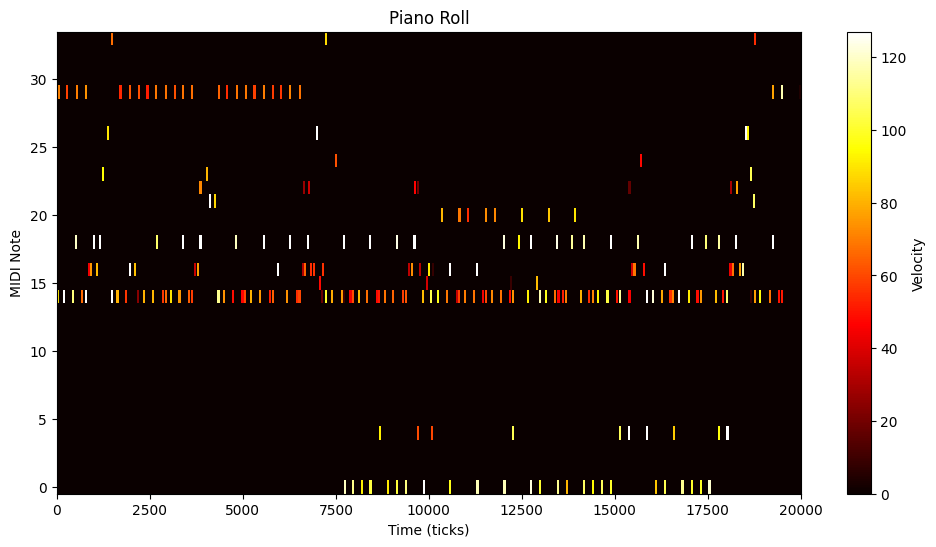

In [12]:

# Plot piano roll
plt.figure(figsize=(12, 6))
plt.imshow(
    piano_roll_df.T,              # transpose so notes are on y-axis
    origin='lower',               # lowest note at the bottom
    aspect='auto',                # scale x and y independently
    cmap='hot',                   # color map
    interpolation='nearest'
)

plt.xlabel("Time (ticks)")
plt.ylabel("MIDI Note")
plt.title("Piano Roll")
plt.colorbar(label="Velocity")
plt.show()

In [13]:
# Analyze MIDI file structure to separate into bars
print("MIDI file properties:")
print(f"Ticks per beat: {midi.ticks_per_beat}")
print(f"Type: {midi.type}")
print(f"Length: {midi.length}")

# Extract tempo and time signature from MIDI meta messages
tempo = 500000  # default tempo (120 BPM)
time_signature = (4, 4)  # default time signature

for track in midi.tracks:
    for msg in track:
        if hasattr(msg, 'tempo'):
            tempo = msg.tempo
            bpm = mido.tempo2bpm(tempo)
            print(f"Tempo: {bpm} BPM")
        elif hasattr(msg, 'numerator') and hasattr(msg, 'denominator'):
            time_signature = (msg.numerator, msg.denominator)
            print(f"Time signature: {time_signature[0]}/{time_signature[1]}")

# Calculate ticks per bar
ticks_per_beat = midi.ticks_per_beat
beats_per_bar = time_signature[0]  # numerator of time signature
ticks_per_bar = ticks_per_beat * beats_per_bar

print(f"Ticks per bar: {ticks_per_bar}")
print(f"Total time in ticks: {time_max}")
print(f"Number of bars: {time_max / ticks_per_bar:.2f}")

MIDI file properties:
Ticks per beat: 480
Type: 1
Length: 35.719648810416665
Tempo: 69.99998833333528 BPM
Time signature: 6/8
Ticks per bar: 2880
Total time in ticks: 20003
Number of bars: 6.95


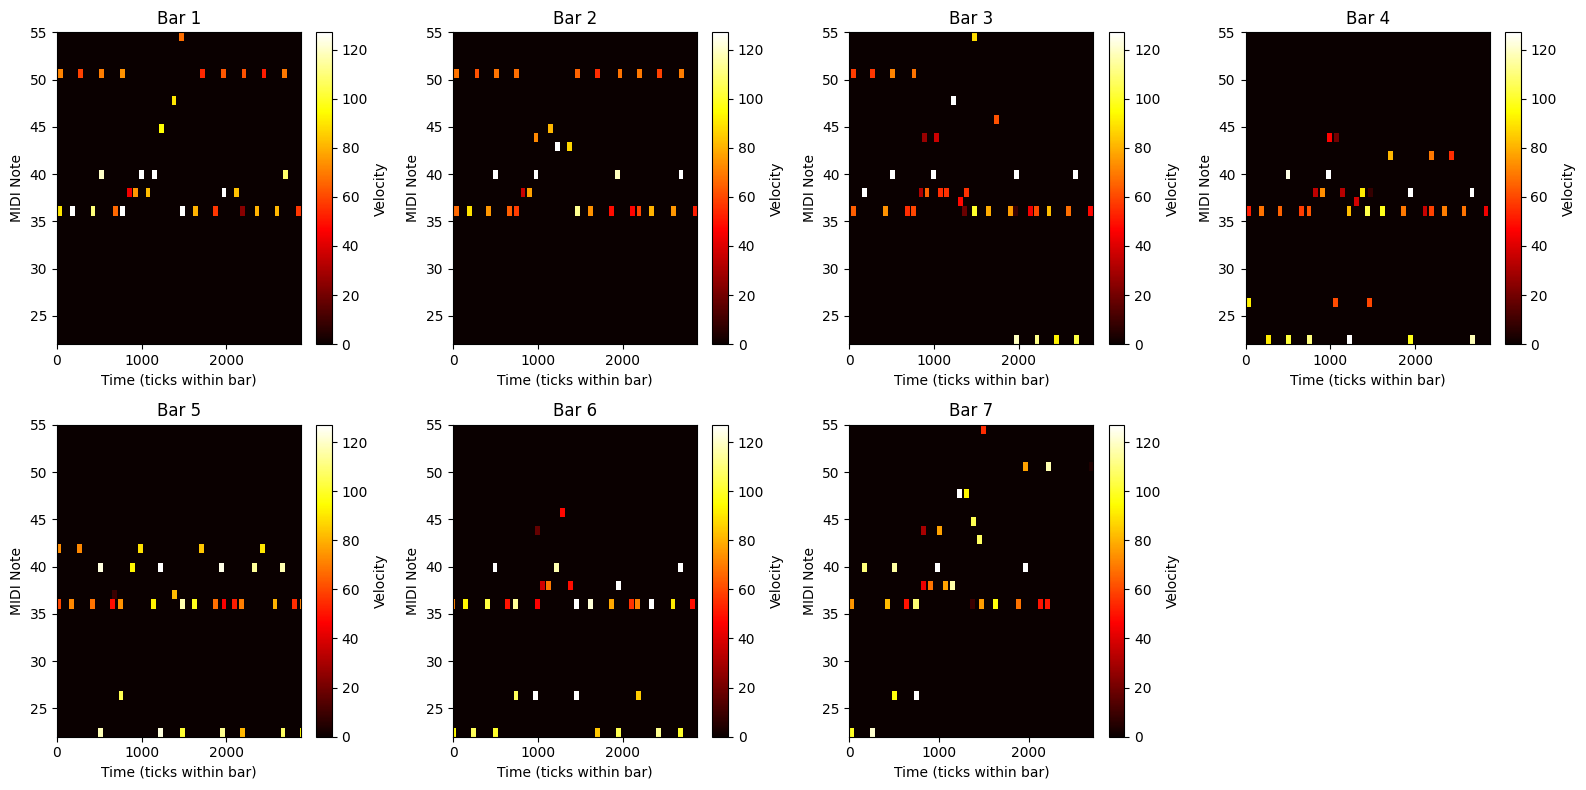

Plotted 7 bars


In [14]:
# Function to separate piano roll into bars and plot each bar
def plot_bars_separately(piano_roll_df, ticks_per_bar, note_min, note_max):
    num_bars = int(np.ceil(len(piano_roll_df) / ticks_per_bar))
    
    # Calculate subplot layout
    cols = min(4, num_bars)  # max 4 columns
    rows = int(np.ceil(num_bars / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
    
    # Handle case where we have only one subplot
    if num_bars == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    
    for bar in range(num_bars):
        start_tick = bar * ticks_per_bar
        end_tick = min((bar + 1) * ticks_per_bar, len(piano_roll_df))
        
        # Extract bar data
        bar_data = piano_roll_df.iloc[start_tick:end_tick]
        
        # Calculate subplot position
        row = bar // cols
        col = bar % cols
        
        if rows > 1:
            ax = axes[row, col]
        else:
            ax = axes[col]
        
        # Plot bar
        im = ax.imshow(
            bar_data.T,
            origin='lower',
            aspect='auto',
            cmap='hot',
            interpolation='nearest',
            extent=[0, len(bar_data), note_min, note_max]
        )
        
        ax.set_xlabel("Time (ticks within bar)")
        ax.set_ylabel("MIDI Note")
        ax.set_title(f"Bar {bar + 1}")
        
        # Add colorbar for each subplot
        plt.colorbar(im, ax=ax, label="Velocity")
    
    # Hide unused subplots
    for bar in range(num_bars, rows * cols):
        row = bar // cols
        col = bar % cols
        if rows > 1:
            axes[row, col].set_visible(False)
        else:
            if col < len(axes):
                axes[col].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return num_bars

# Plot each bar separately
num_bars = plot_bars_separately(piano_roll_df, ticks_per_bar, note_min, note_max)
print(f"Plotted {num_bars} bars")